## Assignment A2a: Signal Detection

### David Courtney 3643806

In [1]:
using Distributions, HDF5, Plots, Random

# 1A / 1B
function genwaveform(;N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype=:Gaussian)
    waveform = zeros(N)
    event_indices = findall(rand(N) .< alpha)

    if noisetype == :Gaussian
        noise = randn(N) * sigma
    elseif noisetype == :Uniform
        noise = (rand(N) .- 0.5) * 2 * sigma
    else
        error("Invalid noise type. Choose 'Gaussian' or 'Uniform'.")
    end

    waveform += noise
    waveform[event_indices] .+= A
    return waveform, event_indices
end

# 2A
function generate_signal(N, A, T)
    x = zeros(T)
    event_times = rand(1:T, N)
    for t in event_times
        x[t] += A
    end
    return x, event_times
end

# 2A
function generate_gaussian_noise(T, mu, sigma)
    epsilon = rand(Normal(mu, sigma), T)
    return epsilon
end

function detection_probability(signal_amplitude, noise_variance, threshold, trials=10000)
    noise = randn(trials) * sqrt(noise_variance)
    signal = ones(trials) * signal_amplitude
    observed = signal + noise
    detected = sum(observed .> threshold) / trials
    return detected
end

# 2B
function detectioncounts(si, y, theta)
    tp = fn = fp = tn = 0
    tp_indices = Int[]
    fn_indices = Int[]
    fp_indices = Int[]
    tn_indices = Int[]

    signal_present = falses(length(y))
    signal_present[si] .= true

    for i in 1:length(y)
        if signal_present[i]
            if y[i] > theta
                tp += 1
                push!(tp_indices, i)
            else
                fn += 1
                push!(fn_indices, i)
            end
        else
            if y[i] > theta
                fp += 1
                push!(fp_indices, i)
            else
                tn += 1
                push!(tn_indices, i)
            end
        end
    end

    return (tp=tp, fn=fn, fp=fp, tn=tn, tp_indices=tp_indices, fn_indices=fn_indices, fp_indices=fp_indices, tn_indices=tn_indices)
end

# 2B
function plot_detection(y, si, theta)

    counts = detectioncounts(si, y, theta)
    tp_indices = counts.tp_indices
    fn_indices = counts.fn_indices
    fp_indices = counts.fp_indices
    tn_indices = counts.tn_indices

    p = plot(legend=:topright, xlabel="Sample", ylabel="Amplitude", title="Signal Detection")

    # Create a dummy series to reserve space for the legend
    dummy_x = [length(y) + 1]  # Place it outside the x-axis range
    dummy_y = [maximum(y) + 1]  # Place it above the y-axis range
    plot!(dummy_x, dummy_y, color=RGBA(0, 0, 0, 0), label="Legend Space")

    hline!([theta], color=:orange, linestyle=:solid, label="Threshold")

    line_color = RGB(0.529, 0.772, 0.972)
    for tp_index in tp_indices
        plot!([tp_index, tp_index], [0, y[tp_index]], color=line_color, label="", linewidth=1)
    end

    for fn_index in fn_indices
        plot!([fn_index, fn_index], [0, y[fn_index]], color=line_color, label="", linewidth=1)
    end

    for fp_index in fp_indices
        plot!([fp_index, fp_index], [0, y[fp_index]], color=line_color, label="", linewidth=1)
    end

    for tn_index in tn_indices
        plot!([tn_index, tn_index], [0, y[tn_index]], color=line_color, label="", linewidth=1)
    end

    scatter!(tp_indices, y[tp_indices], label="True Positives (TP)", color=:red, marker=:circle)
    scatter!(fn_indices, y[fn_indices], label="False Negatives (FN)", color=:red, marker=:diamond)
    scatter!(fp_indices, y[fp_indices], label="False Positives (FP)", color=:blue, marker=:diamond)

    return p
end

# 2C
function falsepos(theta; mu=0, sigma=1, N=100, alpha=0.1, A=1, noisetype=:Gaussian)
    noise_dist = Normal(mu, sigma)
    return 1 - cdf(noise_dist, theta)
end

# 2C
function falseneg(theta; mu=0, sigma=1, N=100, alpha=0.1, A=1, noisetype=:Gaussian)
    signal_plus_noise_dist = Normal(A + mu, sigma)
    return cdf(signal_plus_noise_dist, theta)
end

# 3B
function plotROC(; mu=0, sigma=1, N=100, alpha=0.1, A=1)
    thresholds = range(mu - 3sigma, mu + 3sigma, length=100)
    fpr = [falsepos(t, mu=mu, sigma=sigma, N=N, alpha=alpha, A=A) for t in thresholds]
    fnr = [falseneg(t, mu=mu, sigma=sigma, N=N, alpha=alpha, A=A) for t in thresholds]
    tpr = 1 .- fnr

    plot(fpr, tpr, label="ROC Curve", xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)", title="ROC Curve")
end


plotROC (generic function with 1 method)

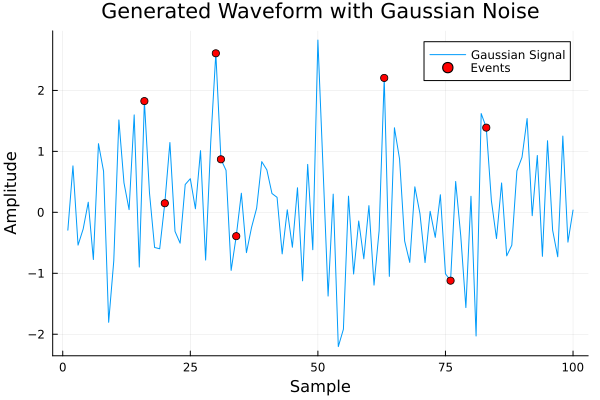

In [2]:
# 1A
waveform, event_indices = genwaveform(;noisetype=:Gaussian)
plot(waveform, title="Generated Waveform with Gaussian Noise", xlabel="Sample", ylabel="Amplitude", label="Gaussian Signal", legend=true)
scatter!(event_indices, waveform[event_indices], color="red", label="Events")

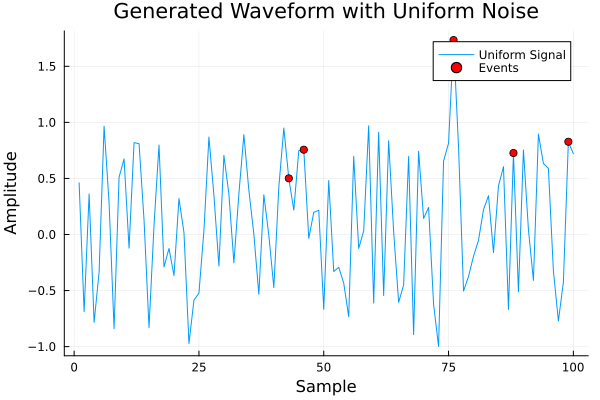

In [3]:
# 1B
waveform, event_indices = genwaveform(;noisetype=:Uniform)
plot(waveform, title="Generated Waveform with Uniform Noise", xlabel="Sample", ylabel="Amplitude", label="Uniform Signal", legend=true)
scatter!(event_indices, waveform[event_indices], color="red", label="Events")

### 1c. Notation
To express the signal $x[t]$ as a sum of $N$ events of amplitude $A$ occurring at times $\tau_i$, you can use the delta function $\delta[t]$ to indicate the presence of these events. The signal $x[t]$ can be represented as:

$$
x[t] = \sum_{i=1}^{N} A \cdot \delta[t - \tau_i]
$$

This equation signifies that the signal $x[t]$ at time $t$ is the sum of $N$ impulses, each of amplitude $A$, occurring at discrete times $\tau_i$. The delta function $\delta[t - \tau_i]$ ensures that the contribution to the sum is $A$ at $t = \tau_i$ and $0$ at all other times.

For the noise $\epsilon[t]$, which is distributed according to a Normal distribution with mean $\mu$ and variance $\sigma^2$, we express this as:

$$
\epsilon[t] \sim \mathcal{N}(\mu, \sigma^2)
$$

Here, $\epsilon[t]$ is understood to be a random variable at each time $t$ that follows a Gaussian distribution characterized by mean $\mu$ and variance $\sigma^2$. This notation conveys that the noise added to the signal at each time $t$ is drawn from this distribution, introducing variability to the observed samples $y[t]$ according to the formula:

$$
y[t] = x[t] + \epsilon[t]
$$

This framework effectively combines deterministic events in $x[t]$ with stochastic variations represented by $\epsilon[t]$, capturing the essence of many real-world signals observed in practice.


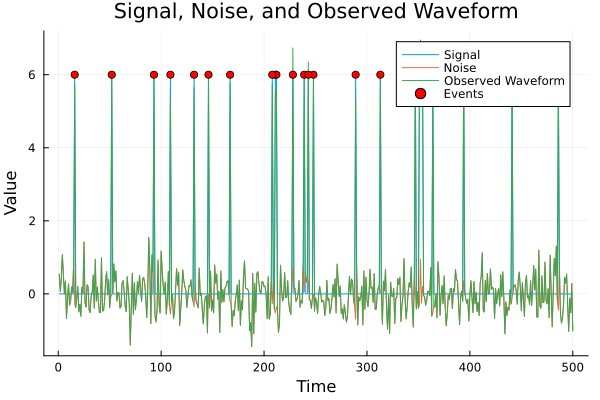

In [4]:
# 1C

T     = 500   # Total time points
N     = 25    # Number of events
A     = 6     # Amplitude of events
mu    = 0     # Mean of Gaussian noise
sigma = 0.5   # Standard deviation of Gaussian noise

signal, event_times = generate_signal(N, A, T)
noise               = generate_gaussian_noise(T, mu, sigma)

y = signal + noise

plot(1:T, signal, label="Signal", title="Signal, Noise, and Observed Waveform", xlabel="Time", ylabel="Value")
plot!(1:T, noise, label="Noise")
plot!(1:T, y, label="Observed Waveform")
scatter!(event_times, signal[event_times], label="Events", color="red", marker=:circle)

### 1d. Conditional probability

The probability of observing a waveform at time $t$ given that there is a signal event can be expressed using conditional probability. Let's denote:

- $y(t)$ as the observed waveform at time $t$.
- $x(t)$ as the signal event at time $t$.
- $\epsilon(t)$ as the noise at time $t$.

We know that the observed waveform is the sum of the signal and the noise: $y(t) = x(t) + \epsilon(t)$.

The probability of the waveform at time $t$ given that there is a signal can be expressed as the probability density function (PDF) of $y(t)$ given $x(t)$. If we know that a signal event occurs at time $t$, the PDF of $y(t)$ is influenced by the known value of $x(t)$ and the distribution of $\epsilon(t)$.

Assuming $\epsilon(t)$ is normally distributed with mean $\mu$ and variance $\sigma^2$, the expression for the conditional probability is:

$$P(y(t) \mid x(t)) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y(t) - x(t) - \mu)^2}{2\sigma^2}\right)$$

This expression is derived from the fact that $y(t)$ is the sum of $x(t)$ and $\epsilon(t)$, and since $\epsilon(t)$ is Gaussian, the distribution of $y(t)$ given $x(t)$ is also Gaussian with a mean shifted by the value of $x(t)$.

It's important to note that this expression assumes that the signal event $x(t)$ has a specific known value at time $t$. If the exact value of $x(t)$ is not known but is instead characterized by some distribution, the expression would need to be modified accordingly.

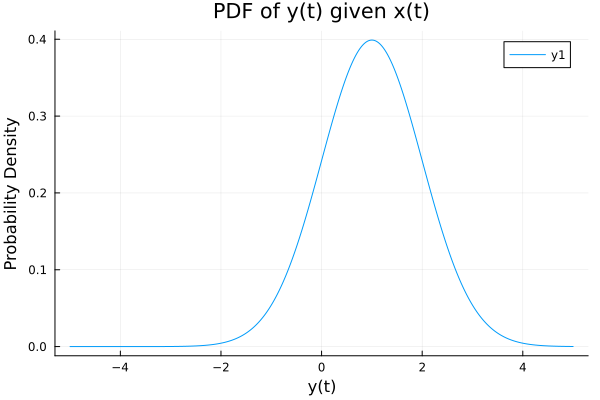

In [5]:
# 1D

# Parameters
mu        = 0
sigma     = 1
x_t       = 1
y_t_range = -5:0.01:5

pdf_y_given_x = pdf.(Normal(x_t + mu, sigma), y_t_range)
plot(y_t_range, pdf_y_given_x, title="PDF of y(t) given x(t)", xlabel="y(t)", ylabel="Probability Density")

## 2. Signal detection

### 2a. Effect of parameters on detection probability

1. **Signal Amplitude (A)**: Higher amplitudes improve detection probability as the signal stands out more from the noise. Lower amplitudes reduce it to near chance levels, especially in high noise.

2. **Noise Variance ($\sigma^2$ for Gaussian Noise)**: Higher variance increases the noise level, making detection harder. Lower variance results in a clearer distinction between signal and noise, enhancing detection.

3. **Type of Noise (Gaussian vs. Uniform)**: Gaussian noise with high variance can make detection more challenging compared to uniform noise with a limited range. Uniform noise with a wide range has similar effects to high-variance Gaussian noise.

4. **Probability of Detection**:
   - Approaches pure chance (0.5) when the signal amplitude is very low or noise variance is very high.
   - Approaches certainty (1) when the signal amplitude is much higher than the noise level.

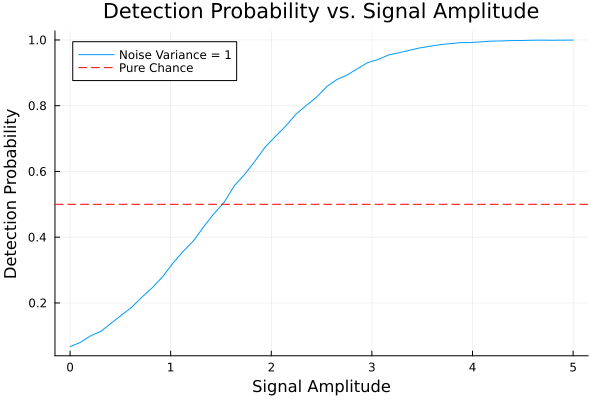

In [6]:
# 2A [Part 1]

signal_amplitudes = range(0, stop=5, length=50)
noise_variance    = 1
threshold         = 1.5

probabilities    = [detection_probability(a, noise_variance, threshold) for a in signal_amplitudes]

plot(signal_amplitudes, probabilities, label="Noise Variance = $noise_variance", title="Detection Probability vs. Signal Amplitude", xlabel="Signal Amplitude", ylabel="Detection Probability")
display(hline!([0.5], color=:red, linestyle=:dash, label="Pure Chance"))


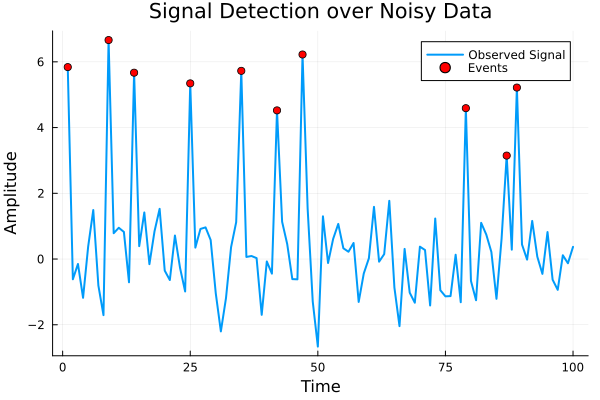

In [7]:
# 2A [Part 1]

# Simulation parameters
N         = 10  # Number of events
A         = 5   # Amplitude of events
T         = 100 # Total time or number of data points
mu        = 0   # Mean of the Gaussian noise
sigma     = 1   # Standard deviation of the Gaussian noise
threshold = 3   # Detection threshold

# Seed the random number generator for reproducibility
#Random.seed!(123)

signal, event_times = generate_signal(N, A, T)
noise = generate_gaussian_noise(T, mu, sigma)
observed_signal = signal + noise

p = plot(1:T, observed_signal, label="Observed Signal", linewidth=2, legend=:topright)
detected_events = event_times[observed_signal[event_times] .> threshold]
scatter!(detected_events, observed_signal[detected_events], label="Events", color="red")
xlabel!("Time")
ylabel!("Amplitude")
title!("Signal Detection over Noisy Data")

p


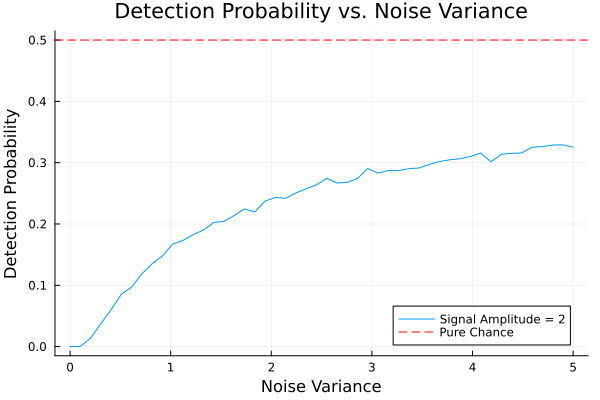

In [8]:
# 2A [Part 2]

noise_variances        = range(0, stop=5, length=50)
fixed_signal_amplitude = 2
probablities_noise     = [detection_probability(fixed_signal_amplitude, v, threshold) for v in noise_variances]

plot(noise_variances, probablities_noise, label="Signal Amplitude = $fixed_signal_amplitude", title="Detection Probability vs. Noise Variance", xlabel="Noise Variance", ylabel="Detection Probability")
display(hline!([0.5], color=:red, linestyle=:dash, label="Pure Chance"))


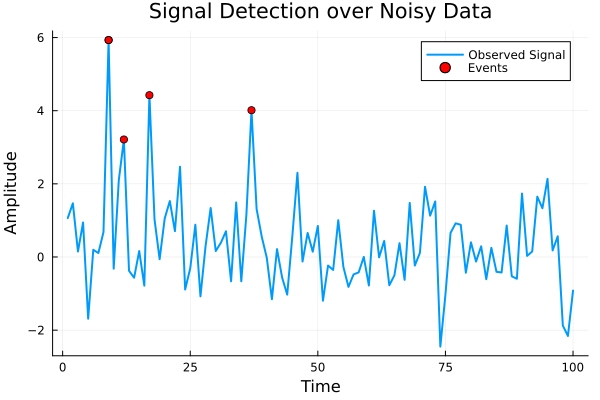

In [9]:
# 2A [Part 2]

# Simulation parameters
N         = 10  # Number of events
A         = 2   # Amplitude of events
T         = 100 # Total time or number of data points
mu        = 0   # Mean of the Gaussian noise
sigma     = 1   # Standard deviation of the Gaussian noise
threshold = 3   # Detection threshold

# Seed the random number generator for reproducibility
#Random.seed!(123)

signal, event_times = generate_signal(N, A, T)
noise = generate_gaussian_noise(T, mu, sigma)
observed_signal = signal + noise

p = plot(1:T, observed_signal, label="Observed Signal", linewidth=2, legend=:topright)
detected_events = event_times[observed_signal[event_times] .> threshold]
scatter!(detected_events, observed_signal[detected_events], label="Events", color="red")
xlabel!("Time")
ylabel!("Amplitude")
title!("Signal Detection over Noisy Data")

p



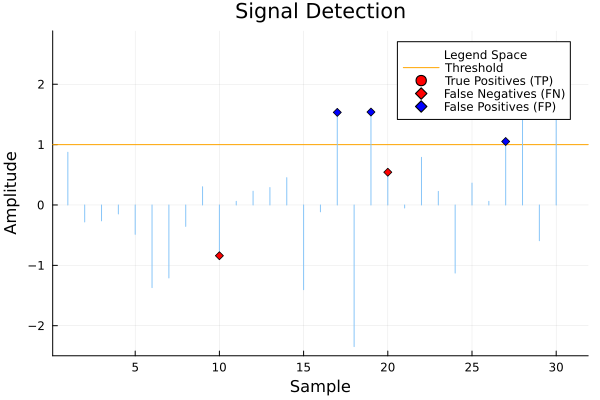

In [10]:
# 2B

y     = randn(30)   # Example data
si    = [10, 20, 30] # Example signal indices
theta = 1            # Example threshold

plot_detection(y, si, theta)

### 2c. Detection probabilities

Probability of a false positive

$\quad$ $P(\text{FP}) = 1 - \Phi\left(\frac{\theta - \mu}{\sigma}\right)$

$\quad$ Where $\theta$ is the threshold. Note that $\theta$ could also be represented as $k$.

Probability of a false negative

$\quad$ $P(\text{FN}) = \Phi\left(\frac{\theta - x(t) - \mu}{\sigma}\right)$

Alternatively, the equation can be written as follows:

$\quad$ $P(\text{FN}) = \Phi\left(\frac{\theta - A - \mu}{\sigma}\right)$


In [11]:
# sample values
theta     = 2     # threshold
alpha     = 0.50
N         = 90
A         = 2
mu        = 2
sigma     = 3
noisetype = :Gaussian

false_positive_rate = falsepos(theta; mu, sigma, N, alpha, A, noisetype)
false_negative_rate = falseneg(theta; mu, sigma, N, alpha, A, noisetype)

println("false positive rate: ", false_positive_rate)
println("false negative rate: ", false_negative_rate)

false positive rate: 0.5
false negative rate: 0.2524925375469229


## 3. ROC cures

### 3a. Threshold considerations

In general, there is no single optimal threshold value ($\theta$) for signal detection due to:

1. **Trade-off between False Positives and False Negatives**: Lowering ($\theta$) decreases false negatives but increases false positives, and vice versa. The ideal balance depends on the specific application's tolerance for each error type.

2. **Variable Signal-to-Noise Ratios**: Optimal thresholds depend on the signal-to-noise ratio, which can vary over time or across different datasets.

3. **Application-Specific Requirements**: Different applications prioritize different error types. For example, medical diagnostics may prioritize minimizing false negatives, while spam filters may focus on reducing false positives.

4. **Changing Signal Characteristics**: Signals with varying characteristics may require different thresholds for effective detection.

5. **Dynamic Environments**: In real-world scenarios, the changing properties of signals and noise can render a fixed threshold ineffective over time. 

Therefore, threshold selection often involves a careful analysis of the specific context and objectives, and may require adaptive strategies in dynamic environments.

To minimize the total error probability in signal detection, the value of the threshold θ should be chosen to minimize the sum of the probabilities of false positives (FP) and false negatives (FN).

Minimizing the total error probability involves reducing the theoretical sum of false positive and false negative probabilities, based on noise and signal distributions. It's a model-based approach used in system design.

Minimizing the total number of errors focuses on reducing the actual count of errors (false positives and false negatives) in observed data. It's an empirical approach influenced by the frequency of signal occurrences in the dataset.

In summary, the former is a theoretical optimization based on distribution models, while the latter is a practical approach based on actual data.


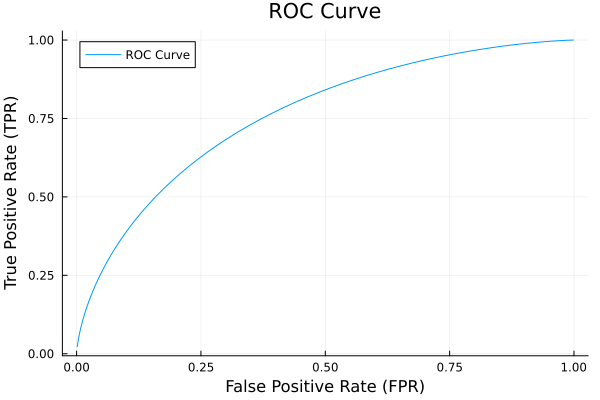

In [12]:
#3B

plotROC(mu=0, sigma=1, N=100, alpha=0.1, A=1)

In [13]:
# Test to ensure file is reading correctly
using HDF5

file_path = "A2a-testdata-one-based-index.h5"
h5open(file_path, "r") do file
    y50 = read(file["testdata/y50"])
    println("Read y50, length: ", length(y50))
    println("First few values of y50: ", y50[1:5])

    i50 = read(file["testdata/i50"])
    println("Read i50, length: ", length(i50))
    println("First few values of i50: ", i50[1:5])
end


Read y50, length: 50
First few values of y50: [-0.8500556703153979, 1.1294094358843267, -1.348533456491827, 3.2402909004290597, -0.055647093207324264]
Read i50, length: 6
First few values of i50: [4, 18, 21, 27, 29]


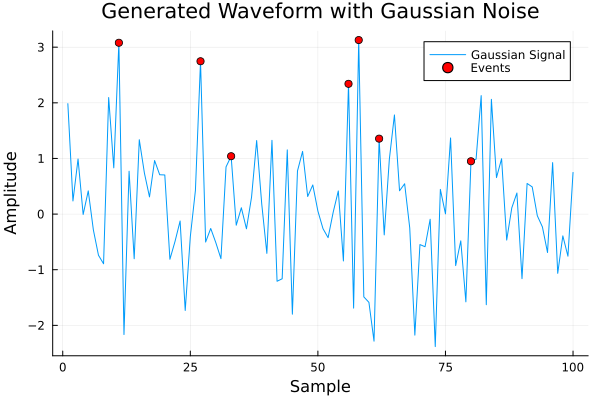

In [14]:
# Question 1
waveform, event_indices = genwaveform(;N=100, alpha=0.05, A=2, sigma=1, noisetype=:Gaussian)
plot(waveform, title=title="Generated Waveform with Gaussian Noise", xlabel="Sample", ylabel="Amplitude", label="Gaussian Signal", legend=true)
scatter!(event_indices, waveform[event_indices], color="red", label="Events")

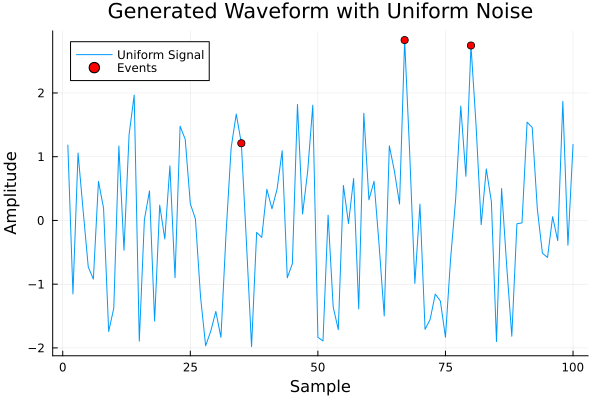

In [15]:
# Question 2
waveform, event_indices = genwaveform(;N=100, alpha=0.05, A=1, mu=0, sigma=2, noisetype=:Uniform)
plot(waveform, title="Generated Waveform with Uniform Noise", xlabel="Sample", ylabel="Amplitude", label="Uniform Signal", legend=true)
scatter!(event_indices, waveform[event_indices], color="red", label="Events")

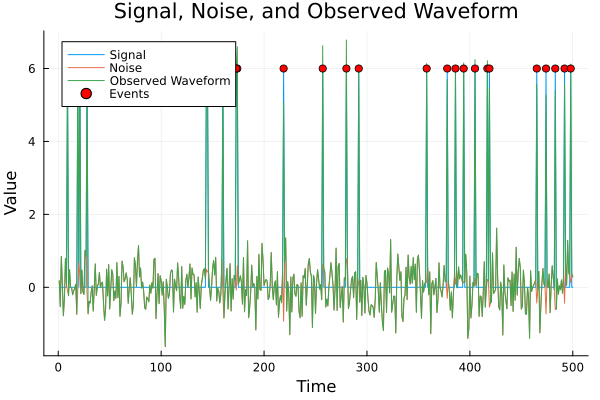

In [16]:
# Question 3 (Copy of 1C)

T     = 500   # Total time points
N     = 25    # Number of events
A     = 6     # Amplitude of events
mu    = 0     # Mean of Gaussian noise
sigma = 0.5   # Standard deviation of Gaussian noise

signal, event_times = generate_signal(N, A, T)
noise               = generate_gaussian_noise(T, mu, sigma)

y = signal + noise

plot(1:T, signal, label="Signal", title="Signal, Noise, and Observed Waveform", xlabel="Time", ylabel="Value")
plot!(1:T, noise, label="Noise")
plot!(1:T, y, label="Observed Waveform")
scatter!(event_times, signal[event_times], label="Events", color="red", marker=:circle)

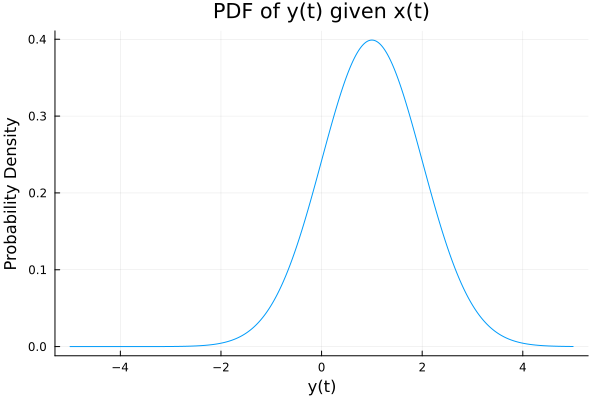

In [17]:
# Question 3 (Copy of 1D)

# Parameters
mu        = 0
sigma     = 1
x_t       = 1
y_t_range = -5:0.01:5

pdf_y_given_x = pdf.(Normal(x_t + mu, sigma), y_t_range)
plot(y_t_range, pdf_y_given_x, title="PDF of y(t) given x(t)", xlabel="y(t)", ylabel="Probability Density", label=false)

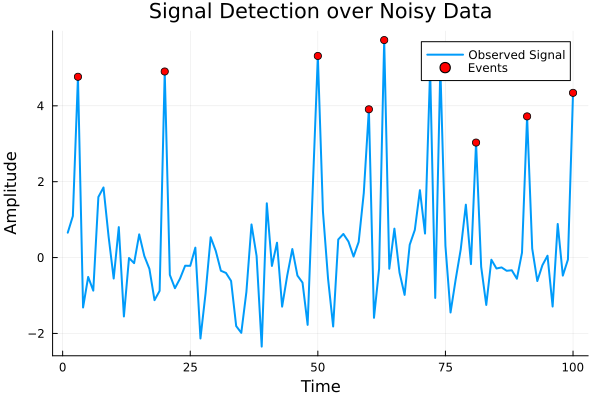

In [18]:
# Question 4 (Copy of 2A [Part 1])

# Simulation parameters
N         = 10  # Number of events
A         = 5   # Amplitude of events
T         = 100 # Total time or number of data points
mu        = 0   # Mean of the Gaussian noise
sigma     = 1   # Standard deviation of the Gaussian noise
threshold = 3   # Detection threshold

# Seed the random number generator for reproducibility
#Random.seed!(123)

signal, event_times = generate_signal(N, A, T)
noise = generate_gaussian_noise(T, mu, sigma)
observed_signal = signal + noise

p = plot(1:T, observed_signal, label="Observed Signal", linewidth=2, legend=:topright)
detected_events = event_times[observed_signal[event_times] .> threshold]
scatter!(detected_events, observed_signal[detected_events], label="Events", color="red")
xlabel!("Time")
ylabel!("Amplitude")
title!("Signal Detection over Noisy Data")

p


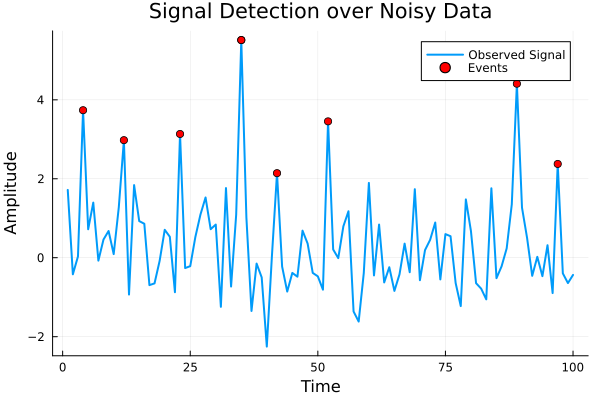

In [19]:
# Question 4 (Copy of 2A [Part 2])

# Simulation parameters
N         = 10  # Number of events
A         = 3   # Amplitude of events
T         = 100 # Total time or number of data points
mu        = 0   # Mean of the Gaussian noise
sigma     = 1   # Standard deviation of the Gaussian noise
threshold = 2   # Detection threshold

# Seed the random number generator for reproducibility
#Random.seed!(123)

signal, event_times = generate_signal(N, A, T)
noise = generate_gaussian_noise(T, mu, sigma)
observed_signal = signal + noise

p = plot(1:T, observed_signal, label="Observed Signal", linewidth=2, legend=:topright)
detected_events = event_times[observed_signal[event_times] .> threshold]
scatter!(detected_events, observed_signal[detected_events], label="Events", color="red")
xlabel!("Time")
ylabel!("Amplitude")
title!("Signal Detection over Noisy Data")

p


In [20]:
# Question 5

y50 = Vector{Float64}()
i50 = Vector{Int}()

file_path = "A2a-testdata-one-based-index.h5"

h5open(file_path, "r") do file
    y50 = read(file["testdata/y50"])
    i50 = read(file["testdata/i50"])
    result = detectioncounts(i50, y50, 1)
    println("True positives: ", result[1])
    println("False negatives: ", result[2])
    println("False positives: ", result[3])
    println("True negatives: ", result[4])
end


True positives: 4
False negatives: 2
False positives: 9
True negatives: 35


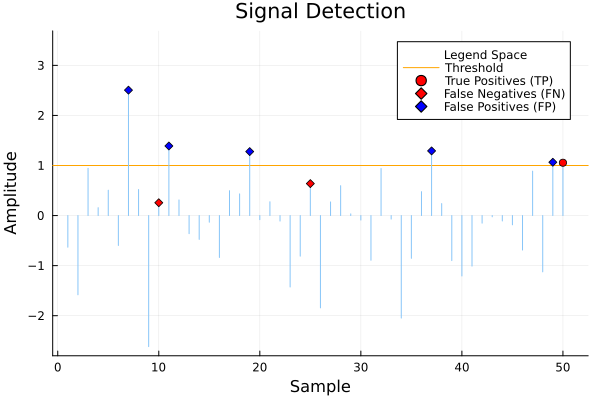

In [21]:
# Question 6 (Copy of 2B)

y     = randn(50)   # Example data
si    = [10, 25, 50] # Example signal indices
theta = 1            # Example threshold

plot_detection(y, si, theta)

In [22]:
# Draft Quiz Question 8

# Given parameters
theta     = 2
alpha     = 0.25
A         = 2
mu        = 0
sigma     = 1
noisetype = :Gaussian

probability_false_positive = falsepos(theta; mu, sigma, alpha, A, noisetype)
println("Probability of a false positive: ", probability_false_positive)


Probability of a false positive: 0.02275013194817921


In [23]:
# Draft Quiz Question 9

threshold_values = 0:0.1:10

total_errors = Float64[]

alpha = 0.25
A     = 2.0
mu    = 0.0
sigma = 1.0

for threshold in threshold_values
    p_false_positive = 1.0 - cdf(Normal(mu, sigma), threshold)
    p_false_negative = cdf(Normal(mu + A, sigma), threshold)
    total_error = (1.0 - alpha) * p_false_positive + alpha * p_false_negative
    push!(total_errors, total_error)
end

min_error = minimum(total_errors)
optimal_threshold_index = argmin(total_errors)
optimal_threshold = threshold_values[optimal_threshold_index]

println("Optimal threshold: ", optimal_threshold)


Optimal threshold: 1.5
